In [24]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, SimpleRNN
from keras.layers import Input
from keras.optimizers import Adam

# 1. 데이터 가져오기 및 분포 확인

In [2]:
# 배추 데이터 가져오기
raw_cabbage = pd.read_csv('C:/sa/cabbage.csv')

# object 타입 쉼표 제거
columns_to_convert = ['exchangeRate', 'retailPrice', 'wholesalePrice', 'exportVolume', 'exportValue', 'importVolume', 'importValue']
for col in columns_to_convert:
    raw_cabbage[col] = raw_cabbage[col].str.replace(',', '')

# 숫자형으로 변환, 변환할 수 없는 값은 NaN으로 설정
raw_cabbage[columns_to_convert] = raw_cabbage[columns_to_convert].apply(pd.to_numeric, errors='coerce')

raw_cabbage.head()

,month,exchangeRate,avgTemp,maxTemp,minTemp,rainfall,retailPrice,wholesalePrice,exportVolume,exportValue,importVolume,importValue,production
0,14-Jan,1065.0,0.7,3.5,4.9,13.0,943,407.0,239150,268976921850,44000,23372490,211567000.0
1,14-Feb,1071.0,1.9,6.6,1.8,16.2,892,357.0,354935,210467565,0,0,211567000.0
2,14-Mar,1071.0,7.9,13.1,3.5,7.2,786,310.0,968363,497062881,0,0,211567000.0
3,14-Apr,1045.0,14.0,19.6,9.4,31.0,796,307.0,1525647,870870605,24000,12497155,211567000.0
4,14-May,1025.0,18.9,25.3,13.8,63.0,736,283.0,3135569,1669132550,0,0,211567000.0


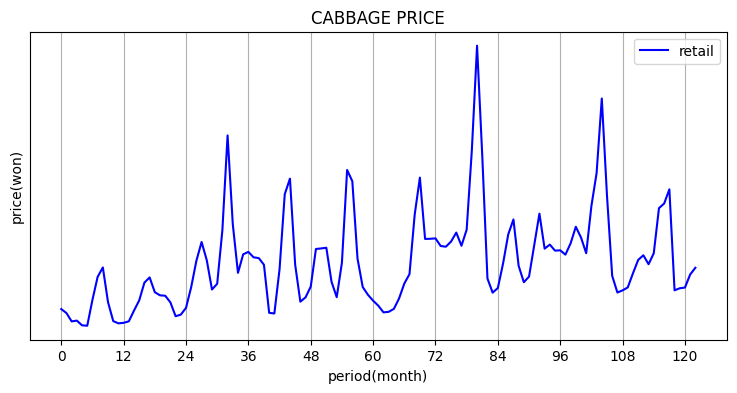

In [3]:
# 배추 분포 확인하기
plt.figure(figsize = (9, 4))
plt.title('CABBAGE PRICE')
plt.ylabel('price(won)')
plt.xlabel('period(month)')
plt.grid()
# x축을 12씩 표시, y축을 500단위로 표시
plt.xticks(range(0, 121, 12))
plt.yticks(range(0, 000, 500))

# 이제 데이터 추가
plt.plot(raw_cabbage['retailPrice'], label='retail', color='b')
plt.legend(loc = 'best')
# 출력
plt.show()

In [4]:
# 최솟값이 0인 열이 있는지 확인
for col in raw_cabbage.columns:

    if raw_cabbage[col].min() == 0:
        col_name = col
        print(col_name, type(col_name))

rainfall <class 'str'>
exportVolume <class 'str'>
exportValue <class 'str'>
importVolume <class 'str'>
importValue <class 'str'>
production <class 'str'>


In [5]:
# 각 column에 0 몇개인지 확인
for col in raw_cabbage.columns:

    missing_rows = raw_cabbage.loc[raw_cabbage[col]==0].shape[0]
    print(col + ': ' + str(missing_rows))

month: 0
exchangeRate: 0
avgTemp: 0
maxTemp: 0
minTemp: 0
rainfall: 2
retailPrice: 0
wholesalePrice: 0
exportVolume: 1
exportValue: 1
importVolume: 68
importValue: 68
production: 3


In [6]:
# 최솟값이 0인 열의 행 출력
raw_cabbage.loc[(raw_cabbage['rainfall'] == 0) | 
                (raw_cabbage['wholesalePrice'] == 0) |
                (raw_cabbage['exportVolume'] == 0) | 
                (raw_cabbage['exportValue'] == 0) | 
                (raw_cabbage['importVolume'] == 0) | 
                (raw_cabbage['importValue'] == 0) | 
                (raw_cabbage['production'] == 0)]

,month,exchangeRate,avgTemp,maxTemp,minTemp,rainfall,retailPrice,wholesalePrice,exportVolume,exportValue,importVolume,importValue,production
1,14-Feb,1071.00,1.9,6.6,1.8,16.2,892,357.0,354935,210467565,0,0,211567000.0
2,14-Mar,1071.00,7.9,13.1,3.5,7.2,786,310.0,968363,497062881,0,0,211567000.0
4,14-May,1025.00,18.9,25.3,13.8,63.0,736,283.0,3135569,1669132550,0,0,211567000.0
6,14-Jul,1020.00,26.1,30.6,22.9,207.9,1060,639.0,576890,483739080,0,0,211567000.0
7,14-Aug,1025.00,25.2,29.0,22.1,172.8,1353,665.0,1144727,856513575,0,0,211567000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,23-Nov,1310.00,6.8,11.5,2.9,81.9,1182,NaN,3566024,3103256380,0,0,103534000.0
119,23-Dec,1304.00,1.1,5.2,2.5,85.9,1208,NaN,1394899,1172582880,0,0,103534000.0
120,24-Jan,1323.57,0.5,3.6,3.9,18.9,1217,NaN,1534527,1295502375,0,0,0.0
121,24-Feb,1331.74,3.8,8.2,0.2,74.7,1383,NaN,584282,548206776,0,0,0.0


In [7]:
# 결측치 처리위해 0을 모두 NaN으로 대체
raw_cabbage['rainfall'] = raw_cabbage['rainfall'].replace(0, np.nan)
raw_cabbage['wholesalePrice'] = raw_cabbage['wholesalePrice'].replace(0, np.nan)
raw_cabbage['exportVolume'] = raw_cabbage['exportVolume'].replace(0, np.nan)
raw_cabbage['exportValue'] = raw_cabbage['exportValue'].replace(0, np.nan)
raw_cabbage['importVolume'] = raw_cabbage['importVolume'].replace(0, np.nan)
raw_cabbage['importValue'] = raw_cabbage['importValue'].replace(0, np.nan)
raw_cabbage['production'] = raw_cabbage['production'].replace(0, np.nan)

# NaN으로 잘 바뀌었나 확인
for col in raw_cabbage.columns:
    missing_rows = raw_cabbage.loc[raw_cabbage[col]==0].shape[0]    # 0의 수 계산
    print(col + ': ' + str(missing_rows))

month: 0
exchangeRate: 0
avgTemp: 0
maxTemp: 0
minTemp: 0
rainfall: 0
retailPrice: 0
wholesalePrice: 0
exportVolume: 0
exportValue: 0
importVolume: 0
importValue: 0
production: 0


In [8]:
# 결측치의 개수가 적은 열은 평균값으로 대체
raw_cabbage.loc[np.isnan(raw_cabbage.rainfall)==True, 'rainfall'] = raw_cabbage.rainfall.mean()
raw_cabbage.loc[np.isnan(raw_cabbage.wholesalePrice)==True, 'wholesalePrice'] = raw_cabbage.wholesalePrice.mean()
raw_cabbage.loc[np.isnan(raw_cabbage.exportVolume)==True, 'exportVolume'] = raw_cabbage.exportVolume.mean()
raw_cabbage.loc[np.isnan(raw_cabbage.exportValue)==True, 'exportValue'] = raw_cabbage.exportValue.mean()
raw_cabbage.loc[np.isnan(raw_cabbage.production)==True, 'production'] = raw_cabbage.production.mean()

# 결측치의 개수가 많은 열은 삭제
raw_cabbage.drop(columns=['importVolume'], inplace=True)
raw_cabbage.drop(columns=['importValue'], inplace=True)

# 결측치 제거가 잘 되었나 확인
for col in raw_cabbage.columns:
    missing_rows = raw_cabbage[col].isna().sum()     # NaN 값 개수 계산
    print(col + ': ' + str(missing_rows))

month: 0
exchangeRate: 0
avgTemp: 0
maxTemp: 0
minTemp: 0
rainfall: 0
retailPrice: 0
wholesalePrice: 0
exportVolume: 0
exportValue: 0
production: 0


### 정규화

In [9]:
# 숫자로 표현되는 모든 column에 대해서 0~1로 정규화를 수행함.
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# 정규화 해줄 열 지정 [열 삭제한 것 때문에, 3가지 케이스]
scale_cols1 = ['exchangeRate', 'avgTemp', 'maxTemp', 'minTemp', 'rainfall', 'retailPrice', 'wholesalePrice', 'exportVolume', 'exportValue', 'production']

# 정규화
scaled_cabbage = scaler.fit_transform(raw_cabbage[scale_cols1])

In [10]:
# numpy형태로 return된 것을 다시 pandas형태로
scaled_cabbage = pd.DataFrame(scaled_cabbage, columns=scale_cols1)
print(scaled_cabbage)

     exchangeRate   avgTemp   maxTemp  minTemp  rainfall  retailPrice  \
0        0.112745  0.017483  0.102410    0.188  0.017786     0.059467   
1        0.127451  0.059441  0.195783    0.064  0.022529     0.045161   
2        0.127451  0.269231  0.391566    0.132  0.009189     0.015428   
3        0.063725  0.482517  0.587349    0.368  0.044464     0.018233   
4        0.014706  0.653846  0.759036    0.544  0.091893     0.001403   
..            ...       ...       ...      ...       ...          ...   
118      0.713235  0.230769  0.343373    0.108  0.119905     0.126508   
119      0.698529  0.031469  0.153614    0.092  0.125834     0.133801   
120      0.746495  0.010490  0.105422    0.148  0.026530     0.136325   
121      0.766520  0.125874  0.243976    0.000  0.109234     0.182889   
122      0.763971  0.230769  0.349398    0.088  0.042834     0.207013   

     wholesalePrice  exportVolume  exportValue  production  
0          0.044413      0.035241     1.000000    1.000000  
1

In [11]:
scaled_cabbage.describe()  # max값과 min값이 1과 0인 것을 확인. 정규화 잘됨. 

,exchangeRate,avgTemp,maxTemp,minTemp,rainfall,retailPrice,wholesalePrice,exportVolume,exportValue,production
count,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000
mean,0.370596,0.470237,0.540479,0.441203,0.149629,0.230755,0.191801,0.262174,0.012793,0.647337
std,0.211120,0.328899,0.301806,0.311312,0.176637,0.171673,0.153654,0.216916,0.089823,0.274474
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.235294,0.129371,0.239458,0.158000,0.035423,0.109537,0.098138,0.095014,0.001600,0.476164
50%,0.316176,0.486014,0.587349,0.368000,0.097228,0.208135,0.184814,0.219057,0.003875,0.688500
75%,0.457108,0.786713,0.828313,0.746000,0.192159,0.296634,0.239971,0.365762,0.007060,0.886718
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
# 학습시킬 훈련데이터와 실험데이터. 
from sklearn.model_selection import train_test_split

# 배추
print("--배추--")
cabbage_X = scaled_cabbage[scaled_cabbage.columns.difference(['retailPrice'])]
cabbage_Y = scaled_cabbage[['retailPrice']]
cabbage_X_train, cabbage_X_test, cabbage_Y_train, cabbage_Y_test = train_test_split(cabbage_X, cabbage_Y, train_size=0.8, test_size=0.2)  # 임의로 사이즈 지정

print(cabbage_X_train.shape); print(cabbage_X_test.shape)
print(cabbage_Y_train.shape); print(cabbage_Y_test.shape)
print(scaled_cabbage.shape)

--배추--
(98, 9)
(25, 9)
(98, 1)
(25, 1)
(123, 10)


In [13]:
from sklearn.feature_selection import f_regression, SelectKBest
# selector 정의. retailPrice와 관련된 feature를 3개 고를 것.      
selector = SelectKBest(score_func=f_regression, k=3)

# 배추
print("--------------배추---------------")
train_selected = selector.fit_transform(cabbage_X_train, cabbage_Y_train.values.ravel())
test_selected = selector.transform(cabbage_X_test)
print(train_selected.shape); print(test_selected.shape)

all_names = cabbage_X_train.columns
selected_mask = selector.get_support()

# 선택된 feature, 선택되지 않은 feature
selected_names = all_names[selected_mask]; unselected_names = all_names[~selected_mask]
print('Selected names:',selected_names); print('Unselected names:',unselected_names)

--------------배추---------------
(98, 3)
(25, 3)
Selected names: Index(['exchangeRate', 'exportVolume', 'wholesalePrice'], dtype='object')
Unselected names: Index(['avgTemp', 'exportValue', 'maxTemp', 'minTemp', 'production',
       'rainfall'],
      dtype='object')


In [14]:
# 배추
print("--------배추---------")
cabbage_feature_cols = ['exchangeRate', 'exportVolume', 'wholesalePrice']
cabbage_label_cols = ['retailPrice']
cabbage_feature_df = pd.DataFrame(scaled_cabbage, columns = cabbage_feature_cols)
cabbage_label_df = pd.DataFrame(scaled_cabbage, columns = cabbage_label_cols)

cabbage_feature_np = cabbage_feature_df.to_numpy()
cabbage_label_np = cabbage_label_df.to_numpy()
print(cabbage_feature_np.shape, cabbage_label_np.shape)

--------배추---------
(123, 3) (123, 1)


### 3. 시계열데이터 생성

In [15]:
window_size = 12    # 계절성을 띨 것으로 예상하고, window size를 12(12달)로 설정.
horizon_factor = 1   # 바로 다음 달 가격 예측.

def sequence_dataset(feature, label, window_size, horizon_factor):
    feature_list = []    # 입력데이터 저장 리스트
    label_list = []      # 정답 데이터 저장 리스트

    for i in range(len(feature) - window_size - horizon_factor + 1):
        feature_list.append(feature[i:i + window_size])
        label_list.append(label[i + window_size + horizon_factor - 1])  # horizon_factor에 따라 label을 설정

    return np.array(feature_list), np.array(label_list)  # 3차원 텐서 형태로 return

cabbage_X, cabbage_Y = sequence_dataset(cabbage_feature_np, cabbage_label_np, window_size, horizon_factor)
print(cabbage_X.shape, cabbage_Y.shape)    # (batch size, time steps, input dims) 형태의 3차원 tensor

(111, 12, 3) (111, 1)


In [16]:
split = int(len(cabbage_X)*0.8)
cabbage_x_train = cabbage_X[0:split]
cabbage_y_train = cabbage_Y[0:split]
cabbage_x_test = cabbage_X[split:]
cabbage_y_test = cabbage_Y[split:]

print(cabbage_x_train.shape, cabbage_y_train.shape)
print(cabbage_x_test.shape, cabbage_y_test.shape)

(88, 12, 3) (88, 1)
(23, 12, 3) (23, 1)


### 4. 모델 구축 및 학습 

In [29]:
model = Sequential()
# 은닉층(뒤에 입력 형태 지정)
model.add(GRU(50, return_sequences = True, activation = 'tanh', input_shape = cabbage_x_train[0].shape))

# GRU 은닉층 추가 (dropout값 : 오버fitting문제 방지)
model.add(GRU(50, activation='tanh', dropout = 0.01))

# 출력층 추가
model.add(Dense(1, activation='linear'))

In [30]:
# Adam 옵티마이저에 learning rate 설정
adam_optimizer = Adam(learning_rate=0.001)

model.compile(loss = 'mse', optimizer = 'adam', metrics = ['mae']) # mae : 오차절댓값
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_3 (GRU)                          │ (None, 12, 50)              │           8,250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_4 (GRU)                          │ (None, 50)                  │          15,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,601 (92.19 KB)

 Trainable params: 23,601 (92.19 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
history = model.fit(cabbage_x_train, cabbage_y_train, 
                    epochs=41, batch_size=3, validation_split=0.2)     

Epoch 1/41
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0074 - mae: 0.0689 - val_loss: 0.0104 - val_mae: 0.0741
Epoch 2/41
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0154 - mae: 0.0993 - val_loss: 0.0068 - val_mae: 0.0682
Epoch 3/41
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0095 - mae: 0.0704 - val_loss: 0.0062 - val_mae: 0.0647
Epoch 4/41
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0077 - mae: 0.0702 - val_loss: 0.0084 - val_mae: 0.0720
Epoch 5/41
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0080 - mae: 0.0700 - val_loss: 0.0096 - val_mae: 0.0730
Epoch 6/41
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0075 - mae: 0.0703 - val_loss: 0.0080 - val_mae: 0.0712
Epoch 7/41
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0073 - mae: 0.0653 - val_loss: 0.0075 - val_mae: 0.0731
Epoch 8/41
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0058 - mae: 0.0571 - val_loss: 0.0084 - val_mae: 0.0706
Epoch 9/41
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.007

In [35]:
loss, mae = model.evaluate(cabbage_x_test, cabbage_y_test)
pred = model.predict(cabbage_x_test)
print("MAPE 값:", sum(abs(cabbage_y_test-pred)/cabbage_y_test)/len(cabbage_x_test))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0472 - mae: 0.1492
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
MAPE 값: [0.71446145]


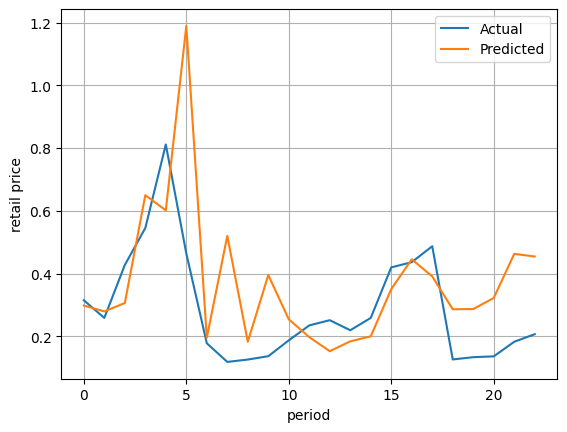

In [36]:
x_range = range(len(cabbage_y_test))  # x축 범위를 테스트 데이터의 길이만큼
plt.plot(x_range, cabbage_y_test[x_range], label='Actual')        # 실제값
plt.plot(x_range, pred[x_range], label = 'Predicted')             # 예측값

plt.ylabel('retail price')            # y축이름
plt.xlabel('period')                  # x축이름
plt.grid()                            # 격자 표시
plt.legend(loc='best')                # 범례 표시

plt.show()   